In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
from numpy import linalg, mean, dot
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [27]:
with open("../collect-data/src/files/nba_data.xlsx", "rb") as file:
    nba_stats_df = pd.read_excel(file, sheet_name="NBA Stats")
    mvp_df = pd.read_excel(file, sheet_name="MVP")

In [28]:
mvp_df["MVP?"] = 1
nba_stats_df["MVP?"] = 0

In [29]:
mvp_dict = mvp_df.to_dict("index")
nba_stats_dict = nba_stats_df.to_dict("index")
mvp_rank_dict = dict()

for k in mvp_dict:
    f_name = mvp_dict[k]["FIRST NAME"]
    l_name = mvp_dict[k]["LAST NAME"]
    team = mvp_dict[k]["TEAM"]
    season = mvp_dict[k]["SEASON"]
    # Filter down dataset
    for i in list(nba_stats_dict):
        if nba_stats_dict[i]["FIRST NAME"] == f_name and nba_stats_dict[i]["LAST NAME"] == l_name and nba_stats_dict[i]["TEAM"] == team and nba_stats_dict[i]["SEASON"] == season:
            nba_stats_dict[i]["MVP?"] = 1
            mvp_rank_dict[nba_stats_dict[i]["SEASON"]] = nba_stats_dict[i]["RANK"]
            nba_stats_dict[i + 1000] = nba_stats_dict[i]

for season in mvp_rank_dict:
    rank = mvp_rank_dict[season]
    if rank > 15:
        max_rank = rank
    else:
        max_rank = 15
    for j in list(nba_stats_dict):
        if nba_stats_dict[j]["SEASON"] == season and nba_stats_dict[j]["RANK"] > max_rank:
            nba_stats_dict.pop(j)

nba_stats_df = pd.DataFrame.from_dict(nba_stats_dict, orient="index")
print(nba_stats_df["MVP?"].value_counts())


MVP?
0    1017
1     213
Name: count, dtype: int64


In [30]:

print(nba_stats_df[nba_stats_df["MVP?"] == "mvp"])

Empty DataFrame
Columns: [RANK, FIRST NAME, LAST NAME, SUFFIX, TEAM, AGE, GP, W, L, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, TOV, STL, BLK, PF, FP, DD2, TD3, +/-, SEASON, MVP?]
Index: []

[0 rows x 34 columns]


In [31]:
model_df = nba_stats_df[['FIRST NAME', 'LAST NAME', 'SUFFIX', 'TEAM', 'AGE', 'SEASON', 'MVP?']]

In [32]:
nba_stats_df.head()

,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON,MVP?
0,1,Luka,Doncic,NaN,DAL,25,70,46,24.0,2624.0,...,282,99,38,149,4304,49,21,319,2023-24,0
1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,75,55,20.0,2552.7,...,162,150,67,184,3939,8,0,613,2023-24,0
2,3,Giannis,Antetokounmpo,NaN,MIL,29,73,45,28.0,2567.2,...,250,87,79,210,4193,57,10,339,2023-24,0
3,4,Jalen,Brunson,NaN,NYK,27,77,49,28.0,2726.3,...,186,70,13,144,3387,9,0,512,2023-24,0
4,5,Nikola,Jokic,NaN,DEN,29,79,55,24.0,2736.5,...,237,108,68,194,4609,68,25,682,2023-24,0


In [33]:
nba_stats_df = nba_stats_df.astype({"RANK": "object"})
nba_stats_df.dtypes

RANK           object
FIRST NAME     object
LAST NAME      object
SUFFIX         object
TEAM           object
AGE             int64
GP              int64
W               int64
L             float64
MIN           float64
PTS             int64
FGM             int64
FGA           float64
FG%           float64
3PM             int64
3PA           float64
3P%           float64
FTM             int64
FTA           float64
FT%           float64
OREB            int64
DREB            int64
REB             int64
AST             int64
TOV             int64
STL             int64
BLK             int64
PF              int64
FP              int64
DD2             int64
TD3             int64
+/-            object
SEASON         object
MVP?            int64
dtype: object

In [34]:
nba_stats_df["+/-"] = nba_stats_df["+/-"].apply(lambda x: int(x) if len(x) < 5 else 0)

In [35]:
# Bin the rankings together
nba_stats_df["RANK"] = pd.cut(nba_stats_df["RANK"], 15)
nba_stats_df["AGE"] = pd.cut(nba_stats_df["AGE"], 5)
nba_stats_df["+/-"] = pd.cut(nba_stats_df["+/-"], 10)
print(nba_stats_df)

                  RANK FIRST NAME           LAST NAME SUFFIX TEAM  \
0      (0.438, 38.467]       Luka              Doncic    NaN  DAL   
1      (0.438, 38.467]       Shai  Gilgeous-Alexander    NaN  OKC   
2      (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
3      (0.438, 38.467]      Jalen             Brunson    NaN  NYK   
4      (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
...                ...        ...                 ...    ...  ...   
13792  (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
14260  (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
13719  (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
14116  (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
13574  (0.438, 38.467]       Joel              Embiid    NaN  PHI   

                AGE  GP   W     L     MIN  ...  TOV  STL  BLK   PF    FP  DD2  \
0      (17.2, 33.4]  70  46  24.0  2624.0  ...  282   99   38  149  4304   49   
1      (1

In [36]:
# rank_enc = pd.get_dummies(nba_stats_df["RANK"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, rank_enc], axis=1)

# age_enc = pd.get_dummies(nba_stats_df["AGE"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, age_enc], axis=1)

# plus_minus_enc = pd.get_dummies(nba_stats_df["+/-"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, plus_minus_enc], axis=1)

# season_enc = pd.get_dummies(nba_stats_df["SEASON"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, season_enc], axis=1)

# team_enc = pd.get_dummies(nba_stats_df["TEAM"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, team_enc], axis=1)

print(nba_stats_df)


                  RANK FIRST NAME           LAST NAME SUFFIX TEAM  \
0      (0.438, 38.467]       Luka              Doncic    NaN  DAL   
1      (0.438, 38.467]       Shai  Gilgeous-Alexander    NaN  OKC   
2      (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
3      (0.438, 38.467]      Jalen             Brunson    NaN  NYK   
4      (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
...                ...        ...                 ...    ...  ...   
13792  (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
14260  (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
13719  (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
14116  (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
13574  (0.438, 38.467]       Joel              Embiid    NaN  PHI   

                AGE  GP   W     L     MIN  ...  TOV  STL  BLK   PF    FP  DD2  \
0      (17.2, 33.4]  70  46  24.0  2624.0  ...  282   99   38  149  4304   49   
1      (1

In [37]:
current_season_df = nba_stats_df[nba_stats_df["SEASON"] == "2023-24"]
nba_stats_df = nba_stats_df[nba_stats_df["SEASON"] != "2023-24"]
print(current_season_df.shape)
print(nba_stats_df.shape)

(573, 34)
(657, 34)


In [38]:
# Change season to int
seasons_list = nba_stats_df["SEASON"].dropna().unique()
season_dict = { None: 1 }
for i in range(len(seasons_list)):
    season = seasons_list[i]
    season_dict[season] = i + 1

nba_stats_df = nba_stats_df.replace({ "SEASON": season_dict })

In [39]:
# nba_stats_df = nba_stats_df[['AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
#        '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
#        'BLK', 'PF', 'FP', 'DD2', 'TD3', 'SEASON', 'MVP?']]
nba_stats_df = nba_stats_df.drop(columns=['RANK', 'MIN', 'PTS', 'FGM', 'FGA', 'AGE', 'FIRST NAME', 'LAST NAME', 'OREB', 'DREB',  'REB', 'SUFFIX', 'FP', 'TEAM', '+/-'], axis=1)
# nba_stats_df = nba_stats_df.drop(columns=['GP',   'W',   'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',  'FTM',  'FTA',  'FT%', 'OREB', 'DREB',  'REB',  'AST',  'TOV', 'STL', 'BLK', 'PF', 'FP','DD2', 'TD3'], axis=1)
nba_stats_df.corr()

,GP,W,L,FG%,3PM,3PA,3P%,FTM,FTA,FT%,AST,TOV,STL,BLK,PF,DD2,TD3,SEASON,MVP?
GP,1.000000,0.461886,-0.488243,0.491618,0.252776,0.254868,-0.351250,0.287905,0.351517,0.007593,0.329269,0.459444,0.394018,-0.152970,-0.418339,0.158178,-0.278432,0.322292,0.070837
W,0.461886,1.000000,-0.208538,0.383912,0.260530,0.227079,-0.099151,0.287718,0.308374,0.086640,0.378224,0.334030,0.294450,0.094699,-0.167375,0.277809,-0.194850,0.011253,0.538671
L,-0.488243,-0.208538,1.000000,-0.755017,-0.182910,-0.201428,0.899595,-0.134333,-0.361082,0.541582,-0.211657,-0.321096,-0.166779,0.400808,0.980282,-0.199054,0.697648,-0.210094,-0.122700
FG%,0.491618,0.383912,-0.755017,1.000000,-0.006815,-0.009624,-0.678202,0.202542,0.423534,-0.309405,0.195902,0.334644,0.079499,-0.057785,-0.701671,0.483477,-0.529061,0.062045,0.326333
3PM,0.252776,0.260530,-0.182910,-0.006815,1.000000,0.984420,0.081821,0.101654,-0.010518,0.267119,0.438249,0.330619,0.404511,-0.513372,-0.216286,-0.256129,-0.104369,-0.290355,0.142051
3PA,0.254868,0.227079,-0.201428,-0.009624,0.984420,1.000000,0.055935,0.162711,0.057622,0.237538,0.473986,0.390116,0.422620,-0.531190,-0.234455,-0.241657,-0.107584,-0.313895,0.134419
3P%,-0.351250,-0.099151,0.899595,-0.678202,0.081821,0.055935,1.000000,-0.099858,-0.378443,0.683247,-0.041017,-0.232002,-0.024380,0.194678,0.871708,-0.272270,0.659356,-0.282950,-0.051349
FTM,0.287905,0.287718,-0.134333,0.202542,0.101654,0.162711,-0.099858,1.000000,0.920200,0.118597,0.238773,0.578897,0.247622,0.106601,-0.092430,0.197126,-0.052993,-0.060972,0.324681
FTA,0.351517,0.308374,-0.361082,0.423534,-0.010518,0.057622,-0.378443,0.920200,1.000000,-0.206177,0.204052,0.600514,0.213278,0.140494,-0.303118,0.328682,-0.213373,0.055642,0.313873
FT%,0.007593,0.086640,0.541582,-0.309405,0.267119,0.237538,0.683247,0.118597,-0.206177,1.000000,0.116660,-0.013795,0.108944,-0.006254,0.519670,-0.240078,0.250598,-0.189127,0.021651


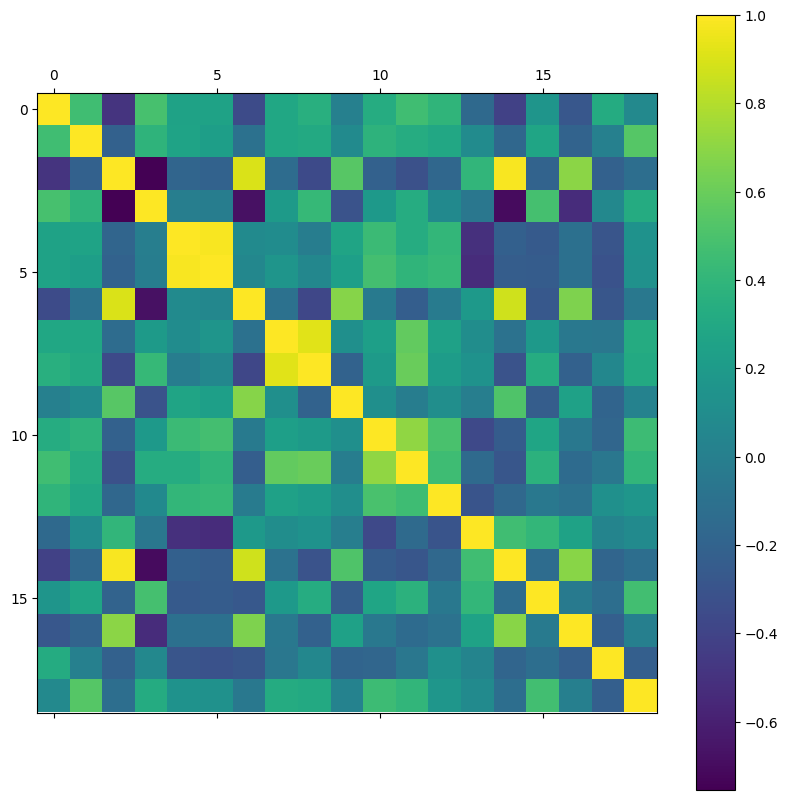

In [40]:
plt.matshow(nba_stats_df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

In [41]:
len(nba_stats_df)

657

In [42]:
nba_stats_df.var()

GP          110.985471
W           153.100359
L         69833.654765
FG%          80.140062
3PM        7564.858995
3PA       45883.531236
3P%         647.643372
FTM       18900.733396
FTA       32625.568454
FT%         154.236069
AST       34154.018209
TOV        4011.065254
STL        1354.605988
BLK        2930.335449
PF        54577.626731
DD2         413.081723
TD3         985.959029
SEASON       59.689864
MVP?          0.219429
dtype: float64

In [43]:
nba_stats_df.cov()

,GP,W,L,FG%,3PM,3PA,3P%,FTM,FTA,FT%,AST,TOV,STL,BLK,PF,DD2,TD3,SEASON,MVP?
GP,110.985471,60.208264,-1359.255705,46.364515,231.616002,575.145382,-94.170966,416.986561,668.895339,0.993472,641.069127,306.545973,152.776079,-87.236733,-1029.599387,33.868508,-92.104591,26.232058,0.349573
W,60.208264,153.100359,-681.876555,42.525070,280.379295,601.856068,-31.221474,489.433734,689.200488,13.313765,864.885441,261.760218,134.092869,63.429774,-483.823748,69.863926,-75.703663,1.075753,3.122181
L,-1359.255705,-681.876555,69833.654765,-1786.133727,-4204.081984,-11401.989760,6049.890231,-4880.402922,-17235.243591,1777.419385,-10336.812714,-5373.994257,-1622.105683,5733.597006,60518.869955,-1069.109235,5788.924447,-428.940442,-15.188861
FG%,46.364515,42.525070,-1786.133727,80.140062,-5.306403,-18.455657,-154.508415,249.274932,684.845388,-34.398945,324.103693,189.730867,26.193511,-28.002465,-1467.457487,87.966828,-148.716782,4.291223,1.368461
3PM,231.616002,280.379295,-4204.081984,-5.306403,7564.858995,18340.425802,181.106346,1215.527715,-165.236004,288.534829,7044.363905,1821.199983,1294.902929,-2417.083619,-4394.779323,-452.769701,-285.036759,-195.110218,5.787518
3PA,575.145382,601.856068,-11401.989760,-18.455657,18340.425802,45883.531236,304.918422,4791.631352,2229.430050,631.909198,18763.523266,5292.386632,3331.848799,-6159.381318,-11732.622657,-1052.074797,-723.611509,-519.472988,13.487608
3P%,-94.170966,-31.221474,6049.890231,-154.508415,181.106346,304.918422,647.643372,-349.373078,-1739.590459,215.942740,-192.910987,-373.929284,-22.835324,268.190959,5182.584623,-140.827003,526.886846,-55.632498,-0.612133
FTM,416.986561,489.433734,-4880.402922,249.274932,1215.527715,4791.631352,-349.373078,18900.733396,22850.747586,202.490815,6066.613884,5040.464816,1252.953407,793.339598,-2968.640471,550.809623,-228.765501,-64.762330,20.909490
FTA,668.895339,689.200488,-17235.243591,684.845388,-165.236004,2229.430050,-1739.590459,22850.747586,32625.568454,-462.499873,6811.465153,6869.605690,1417.853396,1373.712293,-12790.817516,1206.626766,-1210.172923,77.647759,26.557001
FT%,0.993472,13.313765,1777.419385,-34.398945,288.534829,631.909198,215.942740,202.490815,-462.499873,154.236069,267.753518,-10.850682,49.796903,-4.204152,1507.745708,-60.598812,97.723828,-18.146679,0.125954


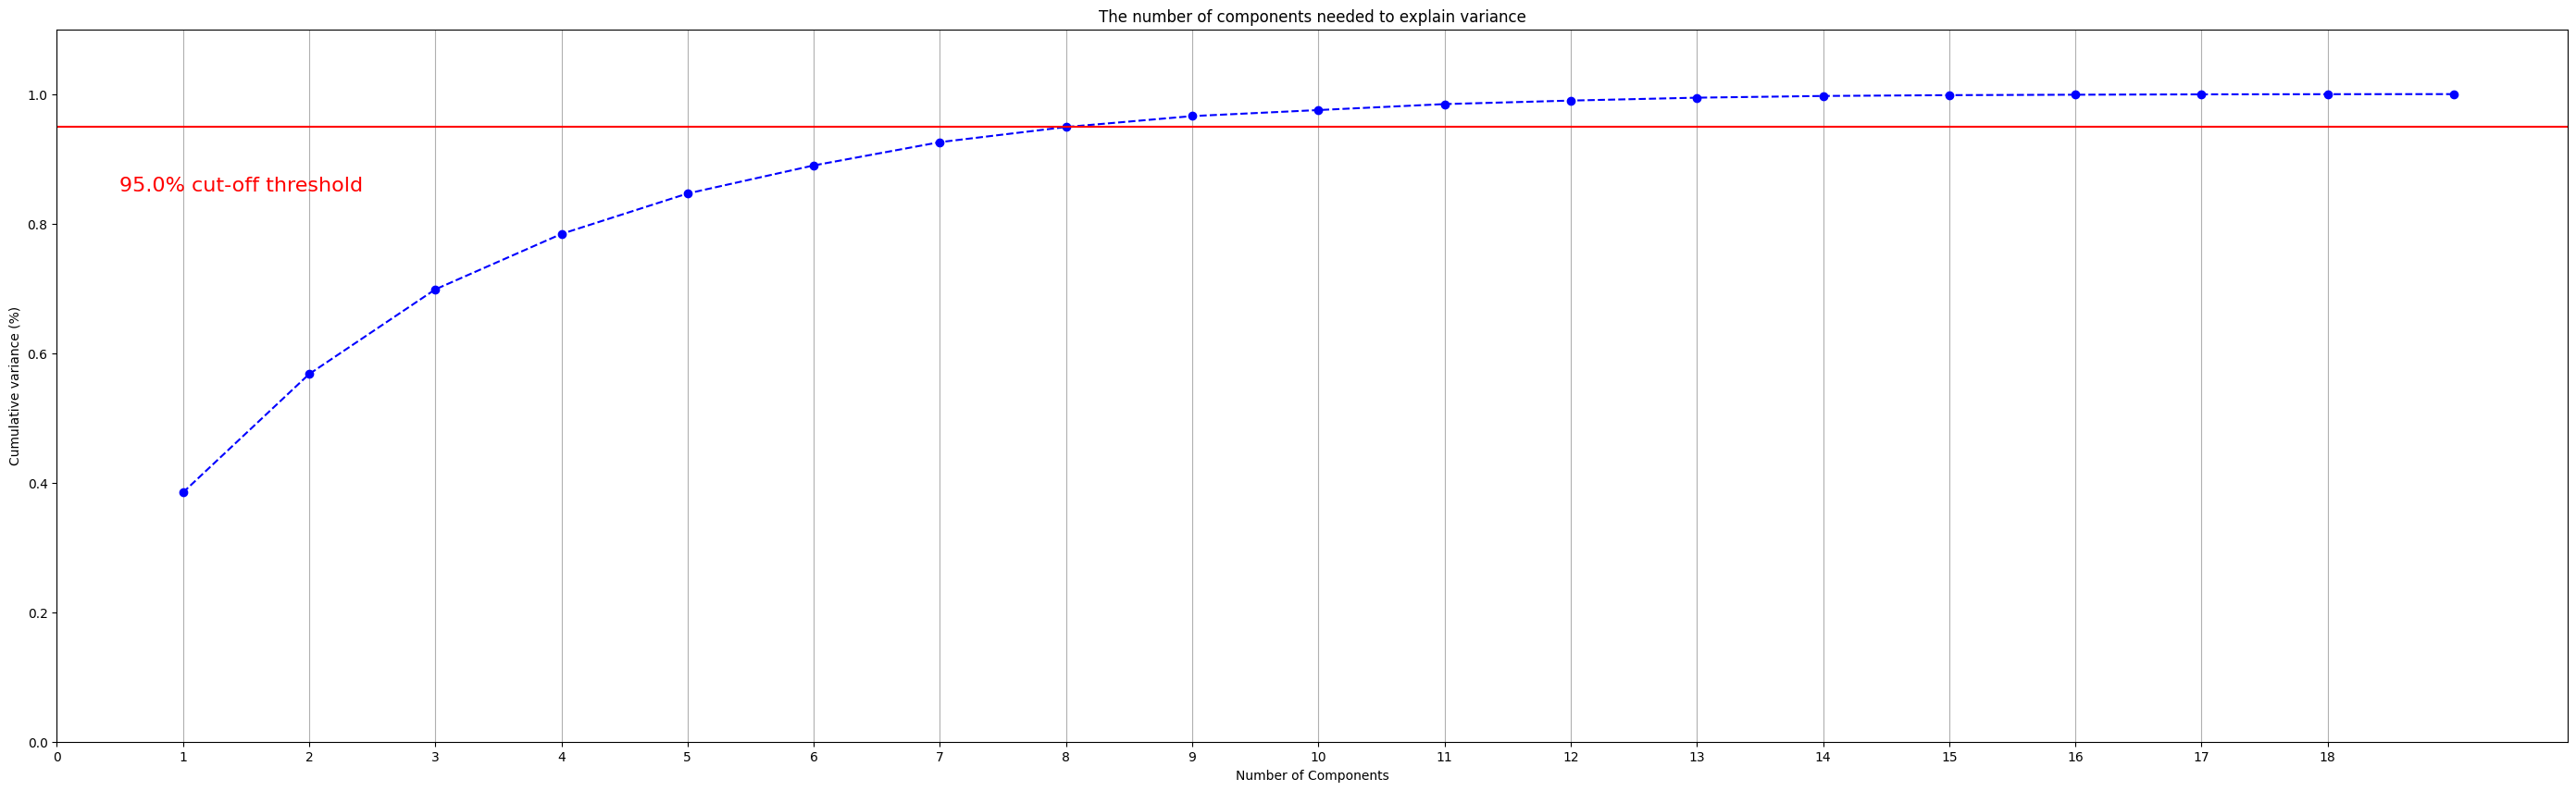

array([[-1.90440712e+02,  2.78333171e+02, -1.03744516e+01, ...,
         4.63547773e-01,  2.80917695e-01,  4.54922399e-01],
       [-6.38249315e+01, -1.17833459e+02, -3.48620347e+02, ...,
         1.81890260e+00,  1.41291153e+00, -3.60288475e-01],
       [-1.96253297e+02,  2.58786025e+02, -1.11264492e+02, ...,
         7.81955251e-01,  1.57872516e-01,  3.41958626e-01],
       ...,
       [-3.12249265e+01,  1.50465690e+01,  1.08004879e+02, ...,
         6.92631621e-01,  8.08244770e-01, -2.25095582e-01],
       [-6.47187081e+01,  6.11244118e+01,  3.77578247e+01, ...,
         2.35125688e+00,  3.50488619e+00, -1.59864070e-01],
       [-6.38249315e+01, -1.17833459e+02, -3.48620347e+02, ...,
         1.81890260e+00,  1.41291153e+00, -3.60288475e-01]])

In [44]:
def generate_pc(columns, variance_pct):
    scaler = MinMaxScaler()
    data_rescaled = scaler.fit_transform(columns.to_numpy())

    pca = PCA().fit(data_rescaled)
    plt.rcParams["figure.figsize"] = (35,10)

    fig, ax = plt.subplots()
    xi = np.arange(1, 20, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker="o", linestyle="--", color="b")

    plt.xlabel("Number of Components")
    plt.xticks(np.arange(0, 19, step=1))
    plt.ylabel("Cumulative variance (%)")
    plt.title("The number of components needed to explain variance")

    plt.axhline(y=variance_pct, color="r", linestyle="-")
    plt.text(0.5, 0.85, f"{variance_pct * 100}% cut-off threshold", color="red", fontsize=16)

    ax.grid(axis="x")
    plt.show()
    return pca
pca = generate_pc(nba_stats_df, 0.95)

pca.fit(nba_stats_df.to_numpy())
pca.transform(nba_stats_df.to_numpy())

In [45]:
# projected.plot(kind="scatter", x="pc1", y="pc2")
nba_stats_df.columns

Index(['GP', 'W', 'L', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'AST',
       'TOV', 'STL', 'BLK', 'PF', 'DD2', 'TD3', 'SEASON', 'MVP?'],
      dtype='object')

In [46]:
# Decision Tree
Y = nba_stats_df["MVP?"]
X = nba_stats_df.drop("MVP?", axis=1)
X.columns = X.columns.astype(str)
max_depths = [2,3,4,5,6,7,8,9,10]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=1)
for depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predtest = clf.predict(X_test)
    Y_predtrain = clf.predict(X_train)
    print("depth:", depth, "test accuracy:", accuracy_score(Y_test, Y_predtest), "train accuracy:", accuracy_score(Y_train, Y_predtrain))
    print(pd.crosstab(Y_test, Y_predtest, rownames = ['Actual'], colnames =['Predicted'], margins = True))

depth: 2 test accuracy: 0.8250950570342205 train accuracy: 0.9389312977099237
Predicted    0    1  All
Actual                  
0          309   32  341
1           60  125  185
All        369  157  526
depth: 3 test accuracy: 0.9163498098859315 train accuracy: 0.9770992366412213
Predicted    0    1  All
Actual                  
0          316   25  341
1           19  166  185
All        335  191  526
depth: 4 test accuracy: 0.8783269961977186 train accuracy: 0.9923664122137404
Predicted    0    1  All
Actual                  
0          313   28  341
1           36  149  185
All        349  177  526
depth: 5 test accuracy: 0.8878326996197718 train accuracy: 1.0
Predicted    0    1  All
Actual                  
0          299   42  341
1           17  168  185
All        316  210  526
depth: 6 test accuracy: 0.9068441064638784 train accuracy: 1.0
Predicted    0    1  All
Actual                  
0          310   31  341
1           18  167  185
All        328  198  526
depth: 7 test a

In [47]:
print(classification_report(Y_test, Y_predtest, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       341
           1       0.84      0.83      0.83       185

    accuracy                           0.88       526
   macro avg       0.87      0.87      0.87       526
weighted avg       0.88      0.88      0.88       526



In [48]:
pd.crosstab(Y_test, Y_predtest, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,311,30,341
1,32,153,185
All,343,183,526


In [49]:
# Predict mvp per season
seasons = nba_stats_df["SEASON"].unique()

for season in seasons:
    print(seasons_list[season - 1])
    season_stats_df = nba_stats_df[nba_stats_df["SEASON"] == season]
    Y = season_stats_df["MVP?"]
    X = season_stats_df.drop("MVP?", axis=1)
    X.columns = X.columns.astype(str)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=43)
    clf = tree.DecisionTreeClassifier(max_depth=8)
    clf = clf.fit(X_train, Y_train)
    Y_predtest = clf.predict(X_test)
    Y_predtrain = clf.predict(X_train)
    print("depth:", depth, "test accuracy:", accuracy_score(Y_test, Y_predtest), "train accuracy:", accuracy_score(Y_train, Y_predtrain))
    print(pd.crosstab(Y_test, Y_predtest, rownames = ['Actual'], colnames =['Predicted'], margins = True))
    print("\n")

2022-23
depth: 10 test accuracy: 0.9722222222222222 train accuracy: 1.0
Predicted   0   1  All
Actual                
0          22   1   23
1           0  13   13
All        22  14   36


2021-22
depth: 10 test accuracy: 1.0 train accuracy: 1.0
Predicted   0   1  All
Actual                
0          13   0   13
1           0  10   10
All        13  10   23


2020-21
depth: 10 test accuracy: 0.9090909090909091 train accuracy: 1.0
Predicted   0   1  All
Actual                
0          10   2   12
1           0  10   10
All        10  12   22


2019-20
depth: 10 test accuracy: 0.9545454545454546 train accuracy: 1.0
Predicted   0   1  All
Actual                
0          11   1   12
1           0  10   10
All        11  11   22


2018-19
depth: 10 test accuracy: 0.7619047619047619 train accuracy: 1.0
Predicted  0   1  All
Actual               
0          7   5   12
1          0   9    9
All        7  14   21


2017-18
depth: 10 test accuracy: 0.8571428571428571 train accuracy: 1.0
Pre

In [50]:
# Results after applying PCA
for season in seasons:
    print(seasons_list[season - 1])
    season_stats_df = nba_stats_df[nba_stats_df["SEASON"] == season]
    Y = season_stats_df["MVP?"]
    X = season_stats_df.drop("MVP?", axis=1)
    X.columns = X.columns.astype(str)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=43)
    pca.fit(X_train)
    explained_variance = pca.explained_variance_ratio_
    cum_explained_ratio = np.cumsum(explained_variance)
    optimal_num_comp = np.where(cum_explained_ratio >= 0.95)[0][0] + 1

    pca = PCA(n_components=optimal_num_comp, svd_solver="full")
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    pca_tree = tree.DecisionTreeClassifier(random_state=42)
    pca_tree = pca_tree.fit(X_train_pca, Y_train)

    Y_pred = pca_tree.predict(X_test_pca)
    print(accuracy_score(Y_test, Y_pred))
    print(pd.crosstab(Y_test, Y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True))

2022-23
0.7222222222222222
Predicted   0   1  All
Actual                
0          13  10   23
1           0  13   13
All        13  23   36
2021-22
0.5652173913043478
Predicted  0   1  All
Actual               
0          3  10   13
1          0  10   10
All        3  20   23
2020-21
0.8181818181818182
Predicted  0   1  All
Actual               
0          8   4   12
1          0  10   10
All        8  14   22
2019-20


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
print(classification_report(Y_test, Y_pred, zero_division=0))

In [ ]:
pd.crosstab(Y_test, Y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)